In [ ]:
COLAB = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


### **Descarga de dataset de imágenes**

In [ ]:
import os

if COLAB:
    try:
        from google_drive_downloader import GoogleDriveDownloader as gdd
    except:
        !pip install googledrivedownloader
        from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1dMuXoXuo1WsXuetYIR7grUHoOuUlxR56',
                                        dest_path='./gender.tgz', unzip=True)

Unzipping...Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

%matplotlib inline

Using TensorFlow backend.


La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [ ]:
import cv2

In [ ]:
def loadImages(root, target_size=(224,224), nimages=False):
    files = os.listdir(root)
    if not nimages:
        nimages = len(files)
    X = []
    for i in range(nimages):
        f = os.path.join(root, files[i])
        img = img_to_array(load_img(f, target_size=target_size))
        X.append(img)
        
    return np.array(X), files


def loadImages2(root, target_size=(224,224), nimages=False):
    files = os.listdir(root)
    if not nimages:
        nimages = len(files)
    X = []
    for i in range(nimages):
        f = os.path.join(root, files[i])
        image = img_to_array(load_img(f))
        frow = 2*int(2*.15*image.shape[0]*.5)
        fcol = int(2*.15*image.shape[1]*.5)
        a = image[:(len(image)-frow),fcol:(image.shape[1]-fcol),:]
        img = cv2.resize(a,target_size)
        X.append(img)
        
    return np.array(X), files


def plot_gallery(images, titles, nrows=3, ncols=4):
    plt.figure(figsize=(1.8*ncols, 2.4*nrows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i]/255)
        plt.title(titles[i], size=12)
        plt.xticks(()); plt.yticks(());


In [ ]:
X_female, files_female = loadImages2('./gender/female')
X_male, files_male     = loadImages2('./gender/male')
print(len(X_female))
print(len(X_male))

1070
1083


In [ ]:
X_female[0].shape

(224, 224, 3)


Estadísticas básicas de la base de datos leída:
  # clases: 2
  # patrones: 2153
  # dimensiones de cada imagen: (224, 224, 3)

Algunas imágenes de la clase "female":

Algunas imágenes de la clase "male":


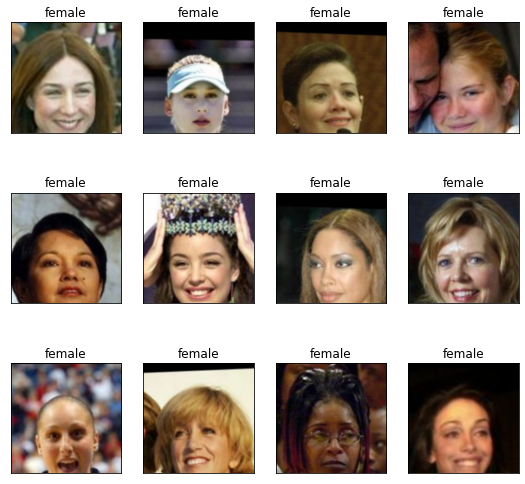

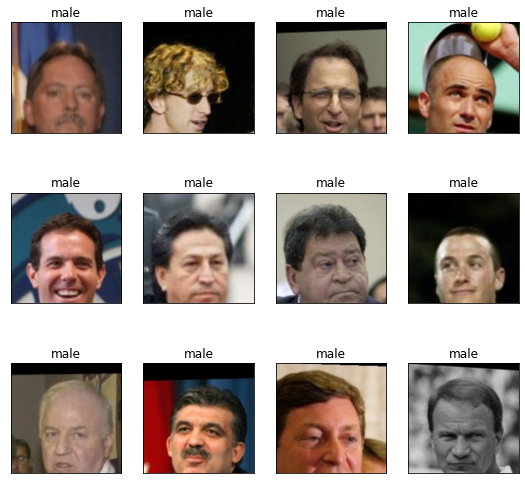

In [ ]:
X = np.concatenate((X_female, X_male))
n_samples = len(X)

target_names = np.array(['female', 'male'])
n_classes = len(target_names)
N_female = len(X_female); N_male = len(X_male)
y_female = N_female*[0]
y_male   = N_male*[1]
y = np.array(y_female+y_male)

print('\nEstadísticas básicas de la base de datos leída:')
print('  # clases: %d' % n_classes)
print('  # patrones: %d' % n_samples)
print('  # dimensiones de cada imagen:', X[0].shape)

print('\nAlgunas imágenes de la clase "female":')
plot_gallery(X_female[:12], 12*['female'])
print('\nAlgunas imágenes de la clase "male":')
plot_gallery(X_male[:12], 12*['male'])

In [ ]:
print(files_male)

['Bruce_Gebhardt_0001.jpg', 'Andy_Dick_0001.jpg', 'Andrew_Weissmann_0002.jpg', 'Andre_Agassi_0033.jpg', 'Brian_Griese_0002.jpg', 'Alejandro_Toledo_0020.jpg', 'Binyamin_Ben-Eliezer_0005.jpg', 'Chistian_Stahl_0001.jpg', 'Alan_Greer_0001.jpg', 'Abdullah_Gul_0012.jpg', 'Ben_Chandler_0001.jpg', 'Barry_Switzer_0001.jpg', 'Armando_Avila_Panchame_0001.jpg', 'Bob_Goldman_0001.jpg', 'Antonio_Palocci_0007.jpg', 'Abdullah_Gul_0006.jpg', 'Adisai_Bodharamik_0001.jpg', 'Alfonso_Portillo_0001.jpg', 'Brian_Billick_0001.jpg', 'Abdullah_al-Attiyah_0003.jpg', 'Arnoldo_Aleman_0004.jpg', 'Benjamin_Netanyahu_0003.jpg', 'Bruce_Lunsford_0001.jpg', 'Bruce_Springsteen_0004.jpg', 'Bernard_Landry_0001.jpg', 'Bill_Stapleton_0001.jpg', 'Bill_Readdy_0001.jpg', 'Anthony_Garotinho_0001.jpg', 'Andrew_Cuomo_0001.jpg', 'Bill_Mauldin_0001.jpg', 'Andre_Agassi_0006.jpg', 'Alberto_Gonzales_0001.jpg', 'Anwar_Ibrahim_0001.jpg', 'Ambrose_Lee_0001.jpg', 'Arnold_Schwarzenegger_0006.jpg', 'Bertrand_Bonello_0002.jpg', 'Buzz_Hargrove

In [ ]:
print(files_female)

['Elsa_Zylberstein_0002.jpg', 'Anna_Kournikova_0003.jpg', 'Clara_Harris_0004.jpg', 'Elizabeth_Smart_0002.jpg', 'Gloria_Macapagal_Arroyo_0007.jpg', 'Azra_Akin_0003.jpg', 'Gina_Torres_0001.jpg', 'Ann_Morgan_0001.jpg', 'Diana_Taurasi_0001.jpg', 'Felicity_Huffman_0001.jpg', 'Esther_Macklin_0001.jpg', 'Heidi_Fleiss_0003.jpg', 'Donatella_Versace_0003.jpg', 'Barbara_Bodine_0001.jpg', 'Emma_Nicholson_0001.jpg', 'Carly_Fiorina_0003.jpg', 'Carmen_Electra_0001.jpg', 'Catherine_Deneuve_0002.jpg', 'Amelie_Mauresmo_0007.jpg', 'Ingrid_Betancourt_0001.jpg', 'Angelina_Jolie_0006.jpg', 'Barbra_Streisand_0002.jpg', 'Dorothy_Loudon_0001.jpg', 'Carol_Niedermayer_0001.jpg', 'Giselle_Estefania_Tavarelli_0001.jpg', 'Carmen_Electra_0002.jpg', 'Alice_Fisher_0002.jpg', 'Gloria_Macapagal_Arroyo_0018.jpg', 'Carly_Gullickson_0001.jpg', 'Deb_Santos_0001.jpg', 'Amy_Yasbeck_0001.jpg', 'Halle_Berry_0016.jpg', 'Danielle_Spencer_0001.jpg', 'Gina_Gershon_0001.jpg', 'Jayne_Yarris_0001.jpg', 'Adelina_Avila_0001.jpg', 'Jacqu

In [ ]:
files = files_female + files_male

In [ ]:
names_female = [x.split('.')[0][:-5] for x in files_female]
names_male   = [x.split('.')[0][:-5] for x in files_male]

In [ ]:
print(names_female[:20])
print()
print(names_male[:20])

['Elsa_Zylberstein', 'Anna_Kournikova', 'Clara_Harris', 'Elizabeth_Smart', 'Gloria_Macapagal_Arroyo', 'Azra_Akin', 'Gina_Torres', 'Ann_Morgan', 'Diana_Taurasi', 'Felicity_Huffman', 'Esther_Macklin', 'Heidi_Fleiss', 'Donatella_Versace', 'Barbara_Bodine', 'Emma_Nicholson', 'Carly_Fiorina', 'Carmen_Electra', 'Catherine_Deneuve', 'Amelie_Mauresmo', 'Ingrid_Betancourt']

['Bruce_Gebhardt', 'Andy_Dick', 'Andrew_Weissmann', 'Andre_Agassi', 'Brian_Griese', 'Alejandro_Toledo', 'Binyamin_Ben-Eliezer', 'Chistian_Stahl', 'Alan_Greer', 'Abdullah_Gul', 'Ben_Chandler', 'Barry_Switzer', 'Armando_Avila_Panchame', 'Bob_Goldman', 'Antonio_Palocci', 'Abdullah_Gul', 'Adisai_Bodharamik', 'Alfonso_Portillo', 'Brian_Billick', 'Abdullah_al-Attiyah']


## **Extracción de características (feature extraction) con Deep Learning**

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense

In [ ]:
from keras import Model
base_model = ResNet50(include_top=False, input_shape=(224,224,3))
#model = ResNet50()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
names     = names_female + names_male
filenames = np.array(files_female + files_male)

In [ ]:
from tqdm import tqdm    

SAVE_PROCESSED_DATA = True

if SAVE_PROCESSED_DATA:
    X_prep = preprocess_input(X.copy())
    extracted_features = []
    for x in tqdm(X_prep):
        extracted_features.append(base_model.predict(np.array([x]))[0])
    extracted_features = np.array(extracted_features)
    
    print(extracted_features.shape)
    print(X[0].min(), X[0].max())
    print(X_prep[0].min(), X_prep[0].max())
    
    np.save("X3.npy", X)
    np.save("y3.npy", y)
    np.save("names3.npy", np.array(names))
    np.save("files3.npy", np.array(files))
    np.save("extracted_features3.npy", extracted_features)
    
else:
    X     = np.load("X3.npy")
    y     = np.load("y3.npy")  
    names = np.load("names3.npy")
    files = np.load("files3.npy")
    extracted_features = np.load("extracted_features3.npy")

  0%|          | 0/2153 [00:00<?, ?it/s]

100%|██████████| 2153/2153 [00:31<00:00, 68.03it/s]


(2153, 7, 7, 2048)
0.0 250.6071
-119.18893 137.83774


## **Partición Training-Validation-Test**

In [ ]:
unique_names = np.unique(names)
len(unique_names)

names_train, names_te = train_test_split(unique_names, test_size=0.3,
                                         random_state=3)
names_tr, names_va = train_test_split(names_train, test_size=0.2,
                                      random_state=8)

In [ ]:
inds_tr = [i for i,n in enumerate(names) if n in names_tr]
inds_va = [i for i,n in enumerate(names) if n in names_va]
inds_te = [i for i,n in enumerate(names) if n in names_te]

In [ ]:
print(len(inds_tr), len(inds_va), len(inds_te))
print(len(inds_tr) + len(inds_va) + len(inds_te))
len(X)

1330 291 532
2153


2153

In [ ]:
y[inds_tr].mean(), y[inds_va].mean(), y[inds_te].mean()

(0.5045112781954887, 0.4845360824742268, 0.5093984962406015)

In [ ]:
X_tr = X[inds_tr]; y_tr = y[inds_tr]
extracted_features_tr = extracted_features[inds_tr]

X_va = X[inds_va]; y_va = y[inds_va]
extracted_features_va = extracted_features[inds_va]

X_te = X[inds_te]; y_te = y[inds_te]
extracted_features_te = extracted_features[inds_te]


In [ ]:
y_tr_sm = np.zeros((len(y_tr),2))
y_tr_sm[:,0] = 1-y_tr; y_tr_sm[:,1] = y_tr

y_va_sm = np.zeros((len(y_va),2))
y_va_sm[:,0] = 1-y_va; y_va_sm[:,1] = y_va

y_te_sm = np.zeros((len(y_te),2))
y_te_sm[:,0] = 1-y_te; y_te_sm[:,1] = y_te


In [ ]:
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import regularizers
from keras.optimizers import Adam, RMSprop

In [ ]:
model_ext = Sequential()
a = extracted_features_tr[0].shape
#model_ext.add(Dropout(0.5, input_shape=a))
#model_ext.add(GlobalAveragePooling2D(input_shape=a))
model_ext.add(Flatten(input_shape=a))
model_ext.add(Dropout(0.5))
model_ext.add(Dense(8+8, activation='relu',
                    kernel_regularizer=regularizers.l1(l=0.1),
                   ))
model_ext.add(Dense(8, activation='relu',
                    kernel_regularizer=regularizers.l1(l=0.1),
                   ))
model_ext.add(Dense(2, activation='softmax'))
model_ext.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

In [ ]:
model_ext.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1605648   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 1,605,802
Trainable params: 1,605,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
#LOAD_MODEL = True
LOAD_MODEL = False

modelpath="best_ext_model_opt_sesgo.h5"

if not LOAD_MODEL:
    epochs = 50
    batch_size = 16
    
    checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') # graba sólo los que mejoran en validación
    callbacks_list = [checkpoint]

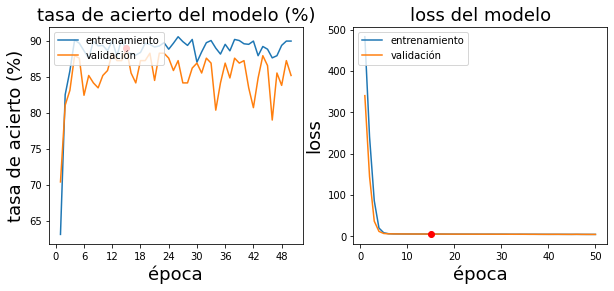

In [ ]:
batch_size = 64
if not LOAD_MODEL:
    for e in range(epochs):
        history = model_ext.fit(extracted_features_tr, y_tr_sm,
                                batch_size=batch_size,
                                epochs=1,
                                callbacks=callbacks_list,
                                verbose=1,
                                validation_data=(extracted_features_va,
                                                 y_va_sm),
                               )
            
        acum_tr_acc.append(history.history['accuracy'][0])
        acum_val_acc.append(history.history['val_accuracy'][0])
        acum_tr_loss.append(history.history['loss'][0])
        acum_val_loss.append(history.history['val_loss'][0])
        
        if len(acum_tr_acc) > 1:
            clear_output()
            best_i = np.argmax(acum_val_acc)
            grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_ext = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
score_tr = model_ext.evaluate(extracted_features_tr, y_tr_sm,
                              verbose=1)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model_ext.evaluate(extracted_features_va, y_va_sm,
                               verbose=1)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model_ext.evaluate(extracted_features_te, y_te_sm,
                              verbose=1)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

1330/1330 [==============================] - 0s 325us/step
Train loss    : 5.273427376711279
Train accuracy: 0.9112781882286072
291/291 [==============================] - 0s 259us/step
Val loss    : 5.292983641739154
Val accuracy: 0.8900343775749207
532/532 [==============================] - 0s 254us/step
Test loss     : 5.310205932846643
Test accuracy : 0.8778195381164551


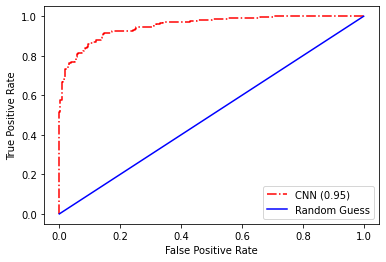

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = model_ext.predict(extracted_features_te)

fpr, tpr, thresholds = roc_curve(y_te_sm[:,0], y_pred_proba[:,0])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model_ext.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1605648   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 1,605,802
Trainable params: 1,605,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_ext.layers[-1].activation

<function keras.activations.softmax>

In [ ]:
aux = model_ext.layers[0](base_model.outputs)
for layer in model_ext.layers[1:]:
    aux = layer(aux)
total_model = Model(inputs=base_model.inputs, outputs=aux)
total_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
file_total_model = "total_model_tratsesgo.h5"
total_model.save(file_total_model)

## **Visualización de heatmaps**

In [ ]:
if COLAB:
    gdd.download_file_from_google_drive(file_id='1Etd4TCBigAjCagnVVx3hFlSiZT8zeBXD',
                                        dest_path='./my_vis.zip')
    !rm -fr my_vis
    !unzip my_vis.zip

Archive:  my_vis.zip
  inflating: my_vis/optimizer.py     
  inflating: my_vis/backprop_modifiers.py  
  inflating: my_vis/grad_modifiers.py  
  inflating: my_vis/callbacks.py     
  inflating: my_vis/losses.py        
  inflating: my_vis/__init__.py      
  inflating: my_vis/input_modifiers.py  
  inflating: my_vis/regularizers.py  
  inflating: my_vis/visualization/__init__.py  
  inflating: my_vis/visualization/saliency.py  
  inflating: my_vis/visualization/activation_maximization.py  
  inflating: my_vis/backend/theano_backend.py  
  inflating: my_vis/backend/tensorflow_backend.py  
  inflating: my_vis/backend/__init__.py  
  inflating: my_vis/utils/__init__.py  
  inflating: my_vis/utils/test_utils.py  
  inflating: my_vis/utils/__pycache__/__init__.cpython-36.pyc  
  inflating: my_vis/utils/__pycache__/utils.cpython-36.pyc  
  inflating: my_vis/visualization/__pycache__/activation_maximization.cpython-36.pyc  
  inflating: my_vis/utils/utils.py   
  inflating: my_vis/visualizati

In [ ]:
from my_vis.visualization import visualize_cam, overlay
from my_vis.utils import utils
from keras.activations import linear

In [ ]:
layer_idx = -1

# Swap softmax (or sigmoid) with linear
total_model.layers[layer_idx].activation = linear
total_model_with_linear_output = utils.apply_modifications(total_model)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
total_model.layers[-1].activation

<function keras.activations.linear>

In [ ]:
total_model_with_linear_output.layers[-1].activation

<function keras.activations.linear>

In [ ]:
total_model = load_model(file_total_model)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
total_model.layers[-1].activation

<function keras.activations.softmax>

In [ ]:
total_model_with_linear_output.layers[-1].activation

<function keras.activations.linear>

In [ ]:
class_idx = 0 # 0: female, 1: male

In [ ]:
ind_te = np.where(filenames[np.array(inds_te)] == "Gwyneth_Paltrow_0002.jpg")[0][0]

Probabilidad hombre: 2.3e+01%


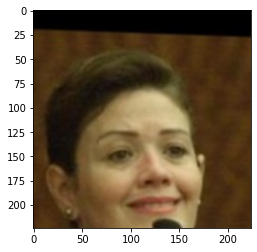

In [ ]:
image = X_te[1] # 0, 10, 20, 60, 200
plt.imshow(image/255, cmap='jet');
p = total_model.predict(np.array([image]))[0,1]
print("Probabilidad hombre: {:2.2}%".format(100*p))

In [ ]:
total_model.predict(np.array([image]))
# probabilidad mujer, probabilidad hombre

array([[0.76614505, 0.23385492]], dtype=float32)

In [ ]:
grads = visualize_cam(total_model_with_linear_output,
                      layer_idx, filter_indices=class_idx,
                      seed_input=preprocess_input(image.copy()),
#                      grad_modifier='relu',
                      backprop_modifier='guided'
#                      backprop_modifier='rectified'
                     )

grads_color = np.zeros(grads.shape + (3,))
grads_color[:,:,0] = grads

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


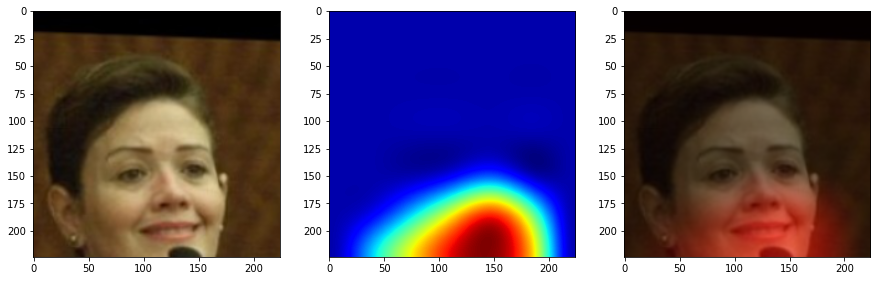

In [ ]:
# Plot with 'jet' colormap to visualize as a heatmap.
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image/255, cmap='jet');
plt.subplot(1,3,2)
plt.imshow(grads, cmap='jet')
plt.subplot(1,3,3)
plt.imshow(overlay(image/255,grads_color), cmap='jet');

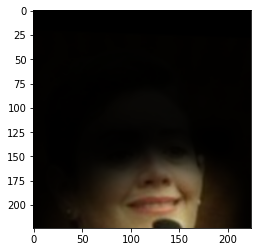

In [ ]:
aux = 1.*image.copy()
aux[:,:,0] *= grads
aux[:,:,1] *= grads
aux[:,:,2] *= grads
plt.imshow(aux.astype(int));